# Natural Language Processing - Text Classification example

###### Links: [News dataset (Kaggle)](https://www.kaggle.com/rmisra/news-category-dataset)  |  [Article (TowardsDataScience)](https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d)

### 0 - Setup

###### Import pckgs

In [1]:
import warnings
warnings.filterwarnings("ignore")
from nlp_utils import *

###### Import data

In [2]:
import json

lst_dics = []
with open('data.json', mode='r', errors='ignore') as json_file:
    for dic in json_file:
        lst_dics.append( json.loads(dic) )
    
lst_dics[0]

{'category': 'CRIME',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'authors': 'Melissa Jeltsen',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.',
 'date': '2018-05-26'}

In [3]:
dtf = pd.DataFrame(lst_dics)
dtf = dtf[ dtf["category"].isin(['ENTERTAINMENT','POLITICS','TECH']) ][["category","headline"]]
dtf = dtf.rename(columns={"category":"y", "headline":"text"})

In [4]:
dtf.sample(5)

,y,text
139112,TECH,A Funeral for Online Appropriateness
27617,POLITICS,Texas Voter ID Law Led To Fears And Failures I...
100565,POLITICS,GOP Eyes Abolishing Supreme Court Filibusters
118937,ENTERTAINMENT,Eminem's Daughter Graduates High School
81338,POLITICS,McConnell Admits Republicans Don't Have The Vo...


In [5]:
dtf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50879 entries, 1 to 200848
Data columns (total 2 columns):
y       50879 non-null object
text    50879 non-null object
dtypes: object(2)
memory usage: 1.2+ MB


### 1 - Text Analysis

###### Look for Metadata
- language detection
- named-entities recognition
- text cleaning
- length analysis
- sentiment analysis
- word frequency
- topic modeling

###### Target Variable

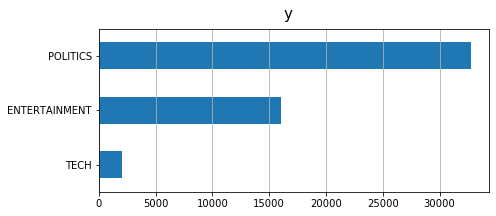

In [6]:
utils_plot_distributions(dtf, x="y", top=None, figsize=(7,3))

In [7]:
# Imbalanced

###### Language Detection

In [8]:
# this takes a while
dtf = add_detect_lang(dtf, "text")
dtf.head()

,y,text,lang
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en


In [9]:
# check
i = 0
print(dtf["text"].iloc[i], " --> ", dtf["lang"].iloc[i])

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song  -->  en


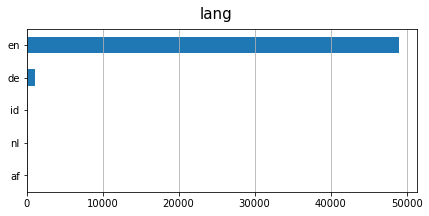

In [10]:
utils_plot_distributions(dtf, x="lang", top=5, figsize=(7,3))

In [11]:
# filter english only
dtf = dtf[dtf["lang"]=="en"]

###### Named-Entity Recognition

In [12]:
ner = spacy.load("en_core_web_lg")

In [13]:
lst_tag_type = ["ORG","PERSON","NORP","GPE","LOC","FAC","EVENT","PRODUCT","WORK_OF_ART"]

In [14]:
ner_displacy(dtf["text"].iloc[0], ner, lst_tag_type, title="NER example")

In [15]:
# example of replacing text and tags extraction
utils_ner_text(dtf["text"].iloc[0], ner, lst_tag_type, grams_join="_")

("Will_Smith Joins Diplo And Nicky_Jam For The_2018_World_Cup's Official Song",
 [('Will Smith', 'PERSON'),
  ('Diplo', 'PERSON'),
  ('Nicky Jam', 'PERSON'),
  ("The 2018 World Cup's", 'EVENT')])

In [16]:
# this takes a while
dtf = add_ner_spacy(dtf, "text", ner, lst_tag_type, grams_join="_", create_features=True)
dtf.head()

--- tagging ---
--- counting tags ---
--- creating features ---


,y,text,lang,text_tagged,tags,tags_PRODUCT,tags_GPE,tags_LOC,tags_PERSON,tags_FAC,tags_NORP,tags_EVENT,tags_WORK_OF_ART,tags_ORG
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,Will_Smith Joins Diplo And Nicky_Jam For The_2...,"[{('Will Smith', 'PERSON'): 1}, {('Diplo', 'PE...",0,0,0,3,0,0,1,0,0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,Hugh_Grant_Marries For The First Time At Age 57,"[{('Hugh Grant Marries', 'PERSON'): 1}]",0,0,0,1,0,0,0,0,0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,Jim_Carrey Blasts 'Castrato' Adam_Schiff And D...,"[{('Jim Carrey', 'PERSON'): 1}, {('Adam Schiff...",0,0,0,2,0,1,0,0,0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,Julianna_Margulies Uses Donald Trump Poop Bags...,"[{('Julianna Margulies', 'PERSON'): 1}]",0,0,0,1,0,0,0,0,0
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,Morgan_Freeman_'Devastated' That Sexual Harass...,"[{('Morgan Freeman '', 'ORG'): 1}]",0,0,0,0,0,0,0,0,1


In [17]:
# check
i = 0
print(dtf["text"].iloc[i], " --> ")
print(dtf["text_tagged"].iloc[i])
print("tags:")
dtf["tags"].iloc[i]

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song  --> 
Will_Smith Joins Diplo And Nicky_Jam For The_2018_World_Cup's Official Song
tags:


[{('Will Smith', 'PERSON'): 1},
 {('Diplo', 'PERSON'): 1},
 {('Nicky Jam', 'PERSON'): 1},
 {("The 2018 World Cup's", 'EVENT'): 1}]

# ENTERTAINMENT:


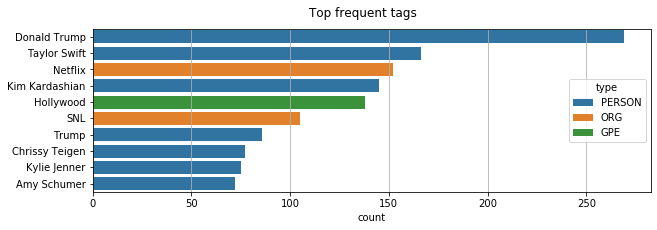

# POLITICS:


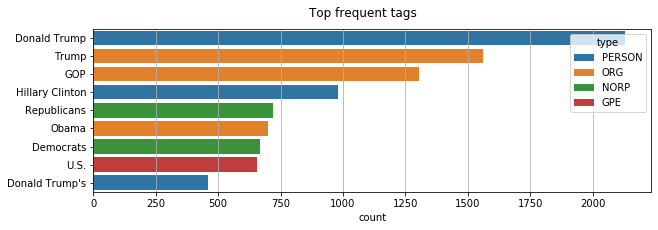

# TECH:


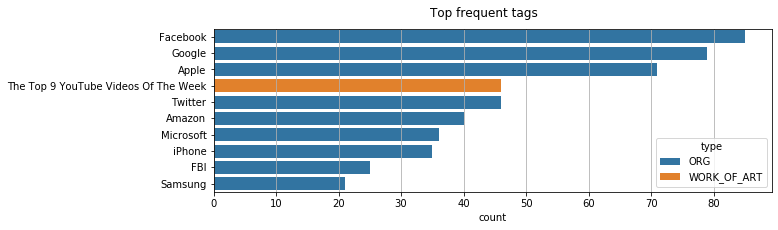

In [18]:
for y in dtf["y"].unique():
    print("# {}:".format(y))
    common_tags = tags_freq(tags=dtf[dtf["y"]==y]["tags"], top=10, figsize=(10,3))

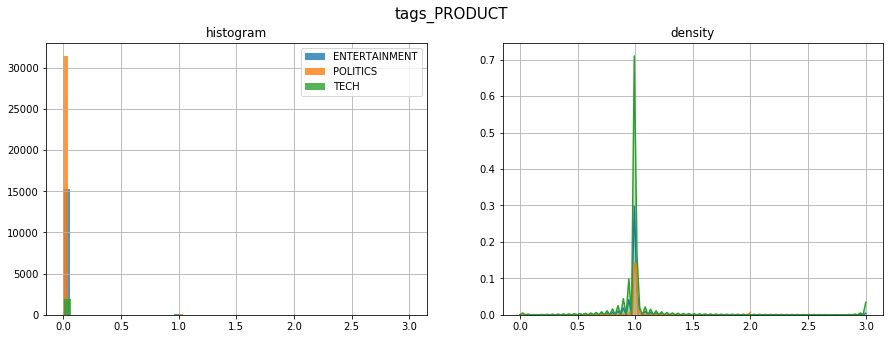

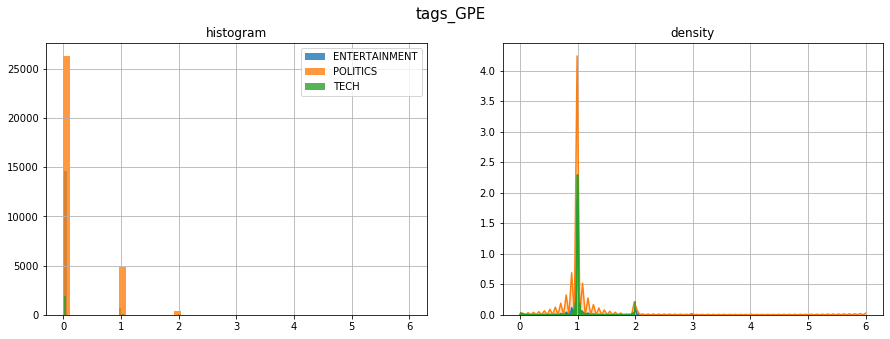

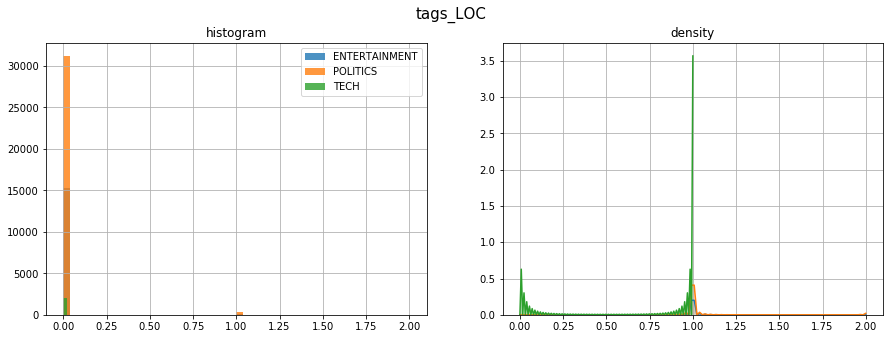

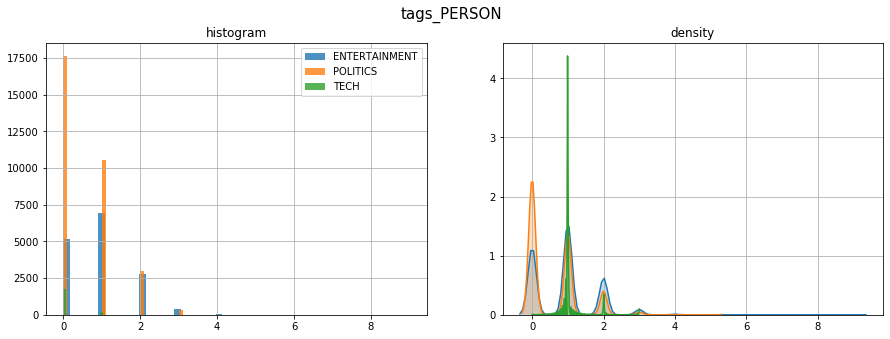

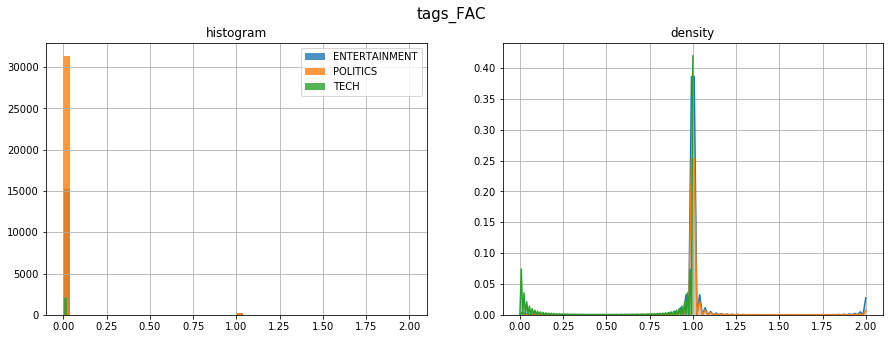

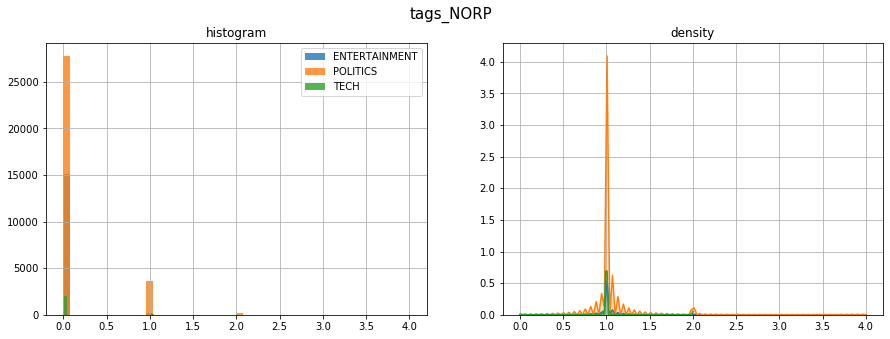

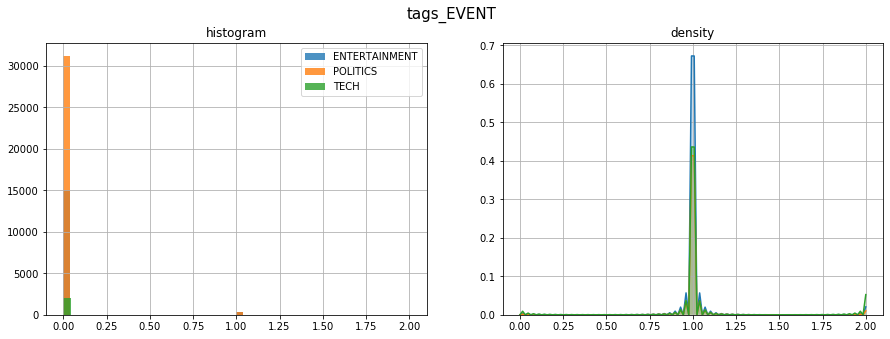

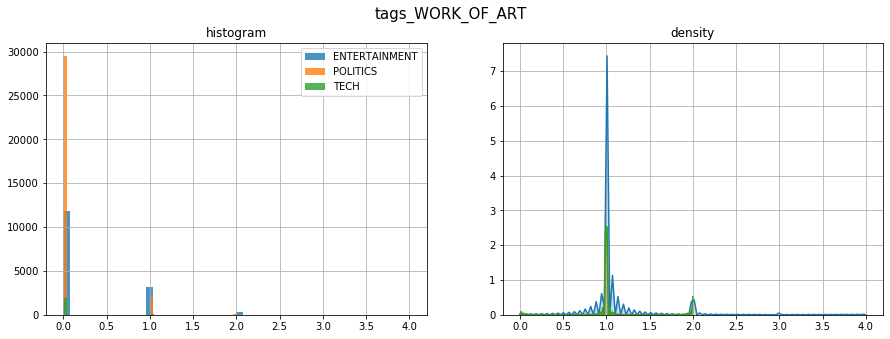

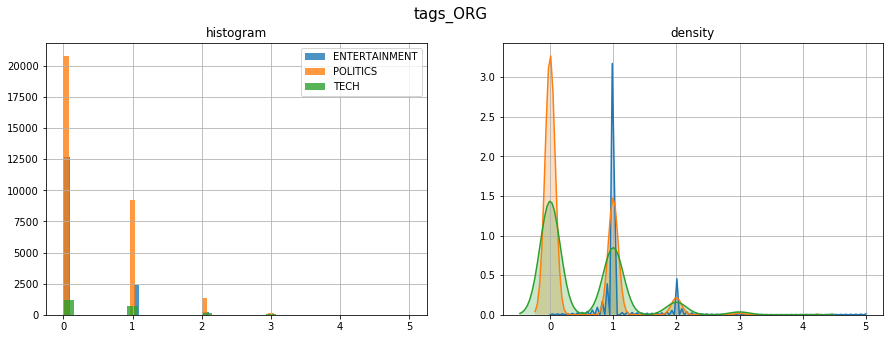

In [19]:
# tags bivariate distribution
for x in dtf.filter(like="tags_", axis=1).columns:
    utils_plot_distributions(dtf, x=x, y="y", bins=None, figsize=(15,5))

###### Text Cleaning

In [20]:
# example
i = 0
print("--- original ---")
print(dtf["text"].iloc[i])

print("--- cleaning ---")
print(utils_preprocess_text(dtf["text"].iloc[i], lst_regex=None, 
                      lst_stopwords=None, flg_stemm=False, flg_lemm=True))

print("--- tokenization ---")
print(dtf["text"].iloc[i].split())

print("--- remove stopwords ---")
print(utils_preprocess_text(dtf["text"].iloc[i], lst_regex=None, 
                      lst_stopwords=set(nltk.corpus.stopwords.words("english")), 
                      flg_stemm=False, flg_lemm=None))

print("--- stemming ---")
print(utils_preprocess_text(dtf["text"].iloc[i], lst_regex=None, 
                      lst_stopwords=set(nltk.corpus.stopwords.words("english")), 
                      flg_stemm=True, flg_lemm=False))

print("--- lemmatisation ---")
print(utils_preprocess_text(dtf["text"].iloc[i], lst_regex=None, 
                      lst_stopwords=set(nltk.corpus.stopwords.words("english")), 
                      flg_stemm=False, flg_lemm=True))

--- original ---
Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song
--- cleaning ---
will smith join diplo and nicky jam for the 2018 world cup official song
--- tokenization ---
['Will', 'Smith', 'Joins', 'Diplo', 'And', 'Nicky', 'Jam', 'For', 'The', '2018', 'World', "Cup's", 'Official', 'Song']
--- remove stopwords ---
smith joins diplo nicky jam 2018 world cups official song
--- stemming ---
smith join diplo nicki jam 2018 world cup offici song
--- lemmatisation ---
smith join diplo nicky jam 2018 world cup official song


In [21]:
# create stopwords
lst_stopwords = create_stopwords(["english"], 
                                 lst_new_words=["dtype","say","new","length","object","u","ha","wa"])

In [22]:
## preprocess text
dtf = add_preprocessed_text(dtf, "text", lst_regex=None, lst_stopwords=lst_stopwords, flg_stemm=False, flg_lemm=True)
dtf.head()

--- found NAs ---
                               text text_clean
10904                      What If?           
31850   This Is Us Is For All Of Us           
92381             WHO Are You Now ?           
121299                 So Now What?           


,y,text,lang,text_tagged,tags,tags_PRODUCT,tags_GPE,tags_LOC,tags_PERSON,tags_FAC,tags_NORP,tags_EVENT,tags_WORK_OF_ART,tags_ORG,text_clean
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,Will_Smith Joins Diplo And Nicky_Jam For The_2...,"[{('Will Smith', 'PERSON'): 1}, {('Diplo', 'PE...",0,0,0,3,0,0,1,0,0,smith join diplo nicky jam 2018 world cup offi...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,Hugh_Grant_Marries For The First Time At Age 57,"[{('Hugh Grant Marries', 'PERSON'): 1}]",0,0,0,1,0,0,0,0,0,hugh grant marries first time age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,Jim_Carrey Blasts 'Castrato' Adam_Schiff And D...,"[{('Jim Carrey', 'PERSON'): 1}, {('Adam Schiff...",0,0,0,2,0,1,0,0,0,jim carrey blast castrato adam schiff democrat...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,Julianna_Margulies Uses Donald Trump Poop Bags...,"[{('Julianna Margulies', 'PERSON'): 1}]",0,0,0,1,0,0,0,0,0,julianna margulies us donald trump poop bag pi...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,Morgan_Freeman_'Devastated' That Sexual Harass...,"[{('Morgan Freeman '', 'ORG'): 1}]",0,0,0,0,0,0,0,0,1,morgan freeman devastated sexual harassment cl...


In [23]:
# check
i = 0
print(dtf["text"].iloc[i], " --> ")
print(dtf["text_clean"].iloc[i])

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song  --> 
smith join diplo nicky jam 2018 world cup official song


###### Length Analysis

In [24]:
dtf = add_text_length(dtf, "text_clean")
dtf.head()

                     min       mean    max
word_count           1.0   7.336888   36.0
char_count           4.0  43.458752  214.0
sentence_count       1.0   1.000000    1.0
avg_word_length      2.5   5.969634   15.0
avg_sentence_lenght  1.0   7.336888   36.0


,y,text,lang,text_tagged,tags,tags_PRODUCT,tags_GPE,tags_LOC,tags_PERSON,tags_FAC,tags_NORP,tags_EVENT,tags_WORK_OF_ART,tags_ORG,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,Will_Smith Joins Diplo And Nicky_Jam For The_2...,"[{('Will Smith', 'PERSON'): 1}, {('Diplo', 'PE...",0,0,0,3,0,0,1,0,0,smith join diplo nicky jam 2018 world cup offi...,10,46,1,4.600000,10.0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,Hugh_Grant_Marries For The First Time At Age 57,"[{('Hugh Grant Marries', 'PERSON'): 1}]",0,0,0,1,0,0,0,0,0,hugh grant marries first time age 57,7,30,1,4.285714,7.0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,Jim_Carrey Blasts 'Castrato' Adam_Schiff And D...,"[{('Jim Carrey', 'PERSON'): 1}, {('Adam Schiff...",0,0,0,2,0,1,0,0,0,jim carrey blast castrato adam schiff democrat...,8,47,1,5.875000,8.0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,Julianna_Margulies Uses Donald Trump Poop Bags...,"[{('Julianna Margulies', 'PERSON'): 1}]",0,0,0,1,0,0,0,0,0,julianna margulies us donald trump poop bag pi...,9,44,1,4.888889,9.0
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,Morgan_Freeman_'Devastated' That Sexual Harass...,"[{('Morgan Freeman '', 'ORG'): 1}]",0,0,0,0,0,0,0,0,1,morgan freeman devastated sexual harassment cl...,9,64,1,7.111111,9.0


In [25]:
# check
i = 0
print(dtf["text_clean"].iloc[i], " --> ")
for col in ["word_count","char_count","sentence_count","avg_word_length","avg_sentence_lenght"]:
    print(col+":", dtf[col].iloc[i])

smith join diplo nicky jam 2018 world cup official song  --> 
word_count: 10
char_count: 46
sentence_count: 1
avg_word_length: 4.6
avg_sentence_lenght: 10.0


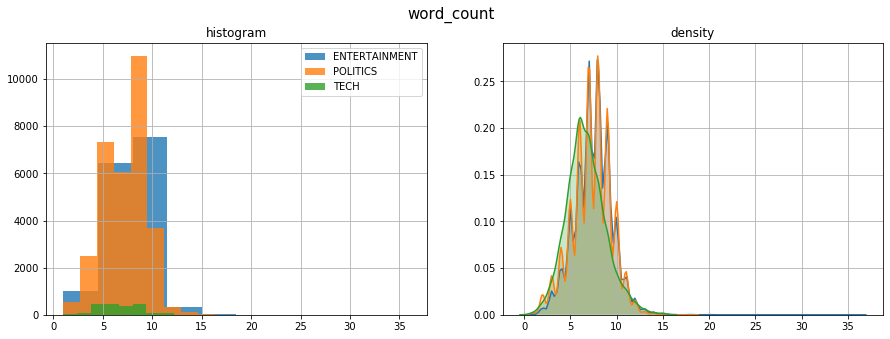

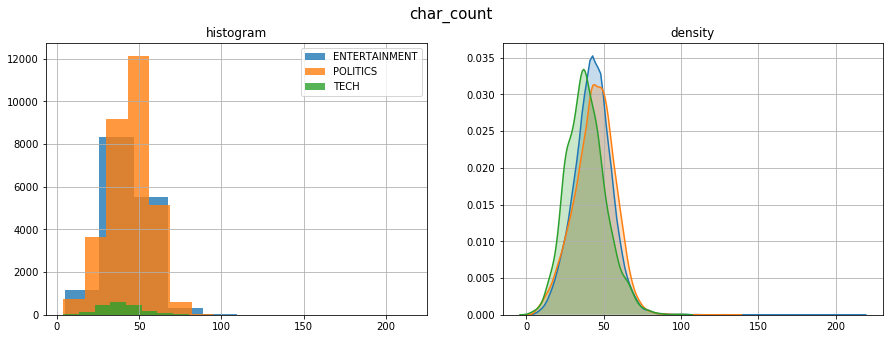

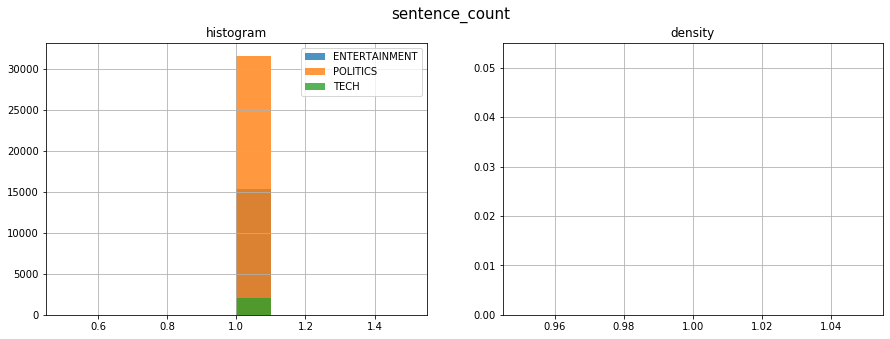

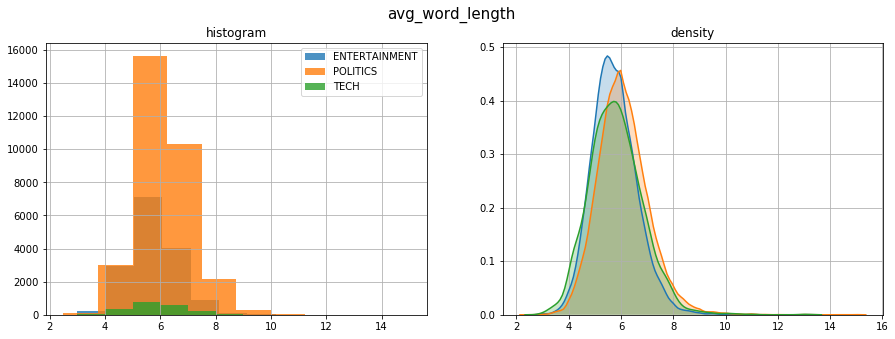

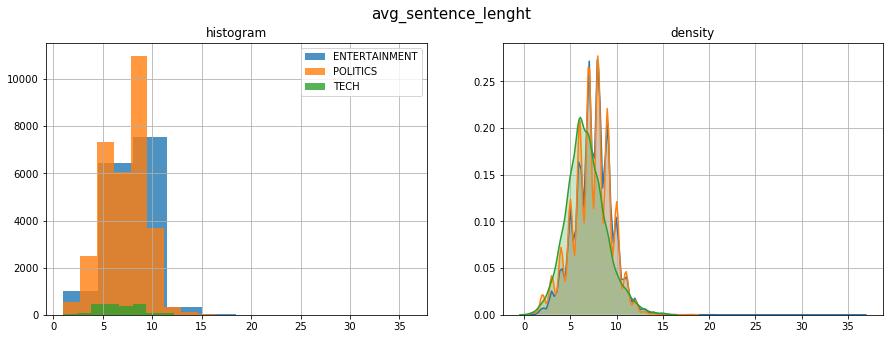

In [26]:
for col in ["word_count","char_count","sentence_count","avg_word_length","avg_sentence_lenght"]:
    utils_plot_distributions(dtf, x=col, y="y", bins=10, figsize=(15,5))

###### Sentiment Analysis

In [27]:
dtf = add_sentiment(dtf, "text_clean", algo="textblob", sentiment_range=(-1,1))
dtf.head()

             count      mean       std  min  25%  50%    75%  max
sentiment  48948.0  0.038863  0.261848 -1.0  0.0  0.0  0.025  1.0


,y,text,lang,text_tagged,tags,tags_PRODUCT,tags_GPE,tags_LOC,tags_PERSON,tags_FAC,...,tags_EVENT,tags_WORK_OF_ART,tags_ORG,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,Will_Smith Joins Diplo And Nicky_Jam For The_2...,"[{('Will Smith', 'PERSON'): 1}, {('Diplo', 'PE...",0,0,0,3,0,...,1,0,0,smith join diplo nicky jam 2018 world cup offi...,10,46,1,4.600000,10.0,0.00
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,Hugh_Grant_Marries For The First Time At Age 57,"[{('Hugh Grant Marries', 'PERSON'): 1}]",0,0,0,1,0,...,0,0,0,hugh grant marries first time age 57,7,30,1,4.285714,7.0,0.25
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,Jim_Carrey Blasts 'Castrato' Adam_Schiff And D...,"[{('Jim Carrey', 'PERSON'): 1}, {('Adam Schiff...",0,0,0,2,0,...,0,0,0,jim carrey blast castrato adam schiff democrat...,8,47,1,5.875000,8.0,0.00
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,Julianna_Margulies Uses Donald Trump Poop Bags...,"[{('Julianna Margulies', 'PERSON'): 1}]",0,0,0,1,0,...,0,0,0,julianna margulies us donald trump poop bag pi...,9,44,1,4.888889,9.0,0.00
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,Morgan_Freeman_'Devastated' That Sexual Harass...,"[{('Morgan Freeman '', 'ORG'): 1}]",0,0,0,0,0,...,0,0,1,morgan freeman devastated sexual harassment cl...,9,64,1,7.111111,9.0,0.50


In [28]:
# check
i = 0
print(dtf["text"].iloc[i], " --> ", dtf["sentiment"].iloc[i])

Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song  -->  0.0


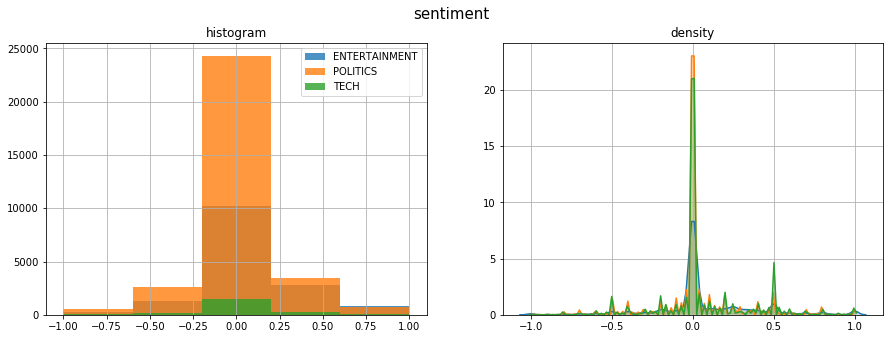

In [29]:
utils_plot_distributions(dtf, x="sentiment", y="y", bins=5, figsize=(15,5))

In [30]:
# I'll give a range of 0-1 to the sentiment
dtf = add_sentiment(dtf, "text_clean", algo="textblob", sentiment_range=(0,1))

             count      mean       std  min  25%  50%     75%  max
sentiment  48948.0  0.519431  0.130924  0.0  0.5  0.5  0.5125  1.0


###### Word frequency

# ENTERTAINMENT:


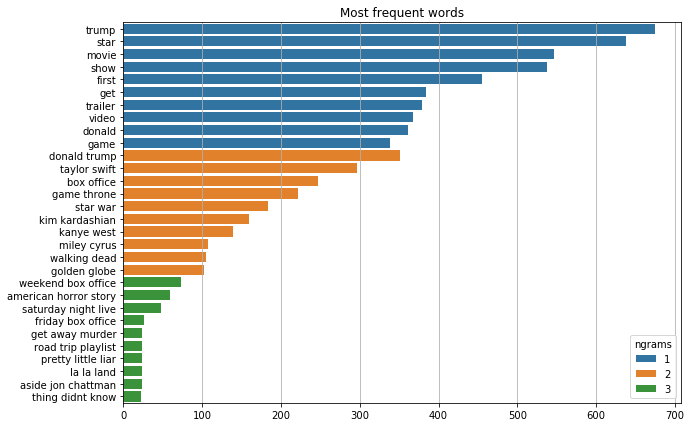

# POLITICS:


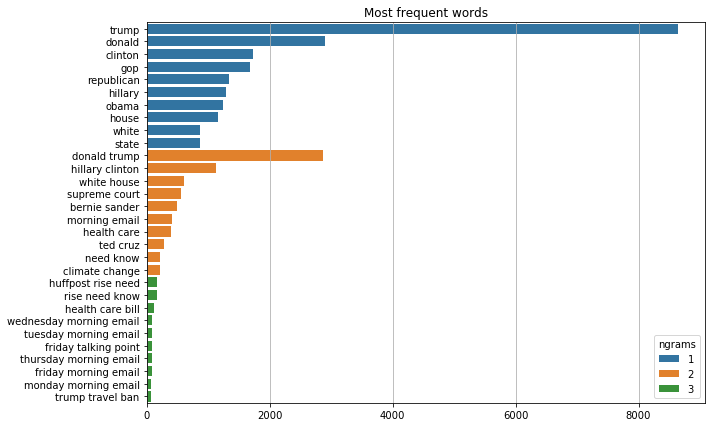

# TECH:


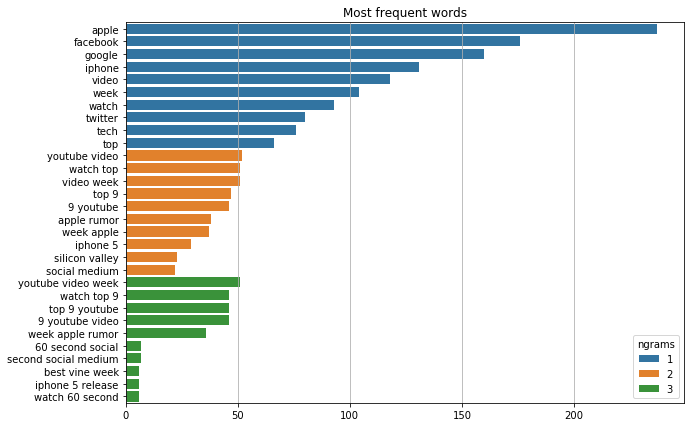

In [31]:
dtf_freq = pd.DataFrame()
for y in dtf["y"].unique():
    print("# {}:".format(y))
    dtf_y = word_freq(corpus=dtf[dtf["y"]==y]["text_clean"], ngrams=[1,2,3], top=10, figsize=(10,7))
    dtf_y["y"] = y
    dtf_freq = dtf_freq.append(dtf_y)

In [32]:
dtf_freq.sample(5)

,word,freq,ngrams,y
62078,watch two,1,2,ENTERTAINMENT
45626,yearn little summertime,1,3,ENTERTAINMENT
12593,injury trump,2,2,POLITICS
10176,frozen reinforces,1,2,ENTERTAINMENT
11748,refund dreadful ordeal,1,3,TECH


# ENTERTAINMENT:


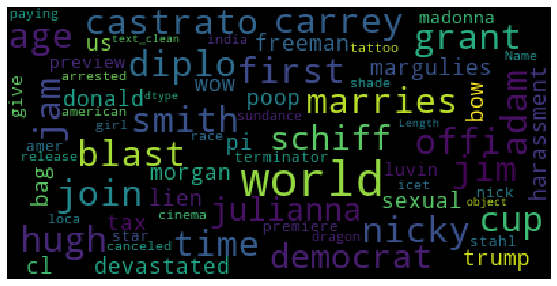

# POLITICS:


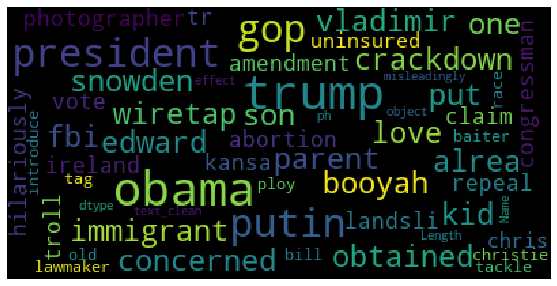

# TECH:


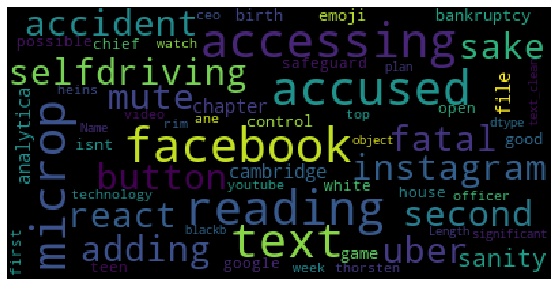

In [33]:
for y in dtf["y"].unique():
    print("# {}:".format(y))
    plot_wordcloud(corpus=dtf[dtf["y"]==y]["text_clean"], max_words=150, max_font_size=35, figsize=(10,5))

In [34]:
dtf = add_word_freq(dtf, "text_clean", lst_words=["box office","republican","apple"], freq="count")
dtf.head()

,y,text,lang,text_tagged,tags,tags_PRODUCT,tags_GPE,tags_LOC,tags_PERSON,tags_FAC,...,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment,box office,republican,apple
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,Will_Smith Joins Diplo And Nicky_Jam For The_2...,"[{('Will Smith', 'PERSON'): 1}, {('Diplo', 'PE...",0,0,0,3,0,...,smith join diplo nicky jam 2018 world cup offi...,10,46,1,4.600000,10.0,0.500,0,0,0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,Hugh_Grant_Marries For The First Time At Age 57,"[{('Hugh Grant Marries', 'PERSON'): 1}]",0,0,0,1,0,...,hugh grant marries first time age 57,7,30,1,4.285714,7.0,0.625,0,0,0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,Jim_Carrey Blasts 'Castrato' Adam_Schiff And D...,"[{('Jim Carrey', 'PERSON'): 1}, {('Adam Schiff...",0,0,0,2,0,...,jim carrey blast castrato adam schiff democrat...,8,47,1,5.875000,8.0,0.500,0,0,0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,Julianna_Margulies Uses Donald Trump Poop Bags...,"[{('Julianna Margulies', 'PERSON'): 1}]",0,0,0,1,0,...,julianna margulies us donald trump poop bag pi...,9,44,1,4.888889,9.0,0.500,0,0,0
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,Morgan_Freeman_'Devastated' That Sexual Harass...,"[{('Morgan Freeman '', 'ORG'): 1}]",0,0,0,0,0,...,morgan freeman devastated sexual harassment cl...,9,64,1,7.111111,9.0,0.750,0,0,0


###### Topic modeling

# ENTERTAINMENT:
--- training ---


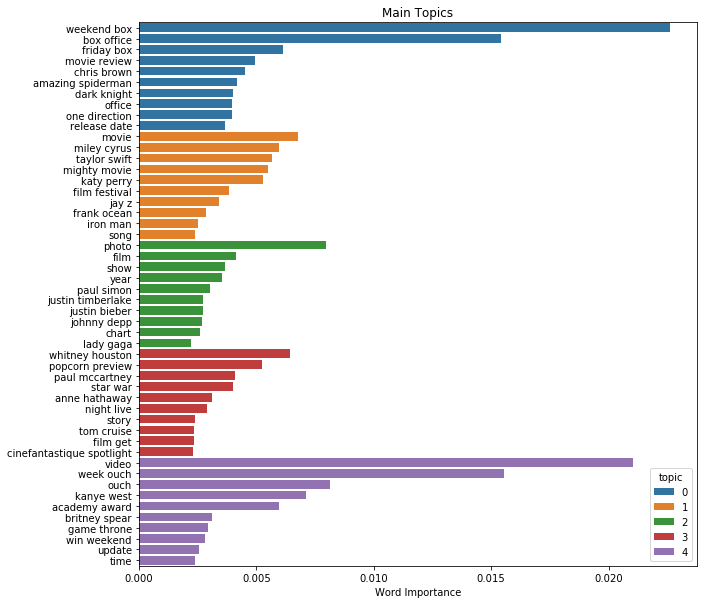

 
# POLITICS:
--- training ---


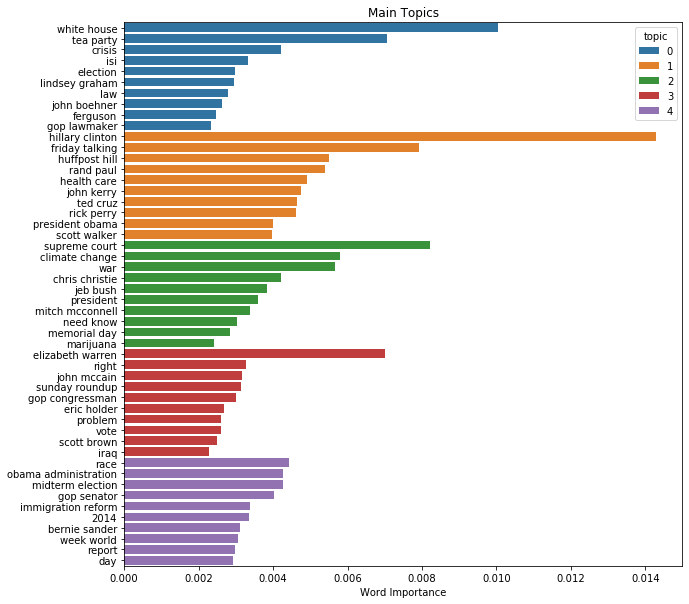

 
# TECH:
--- training ---


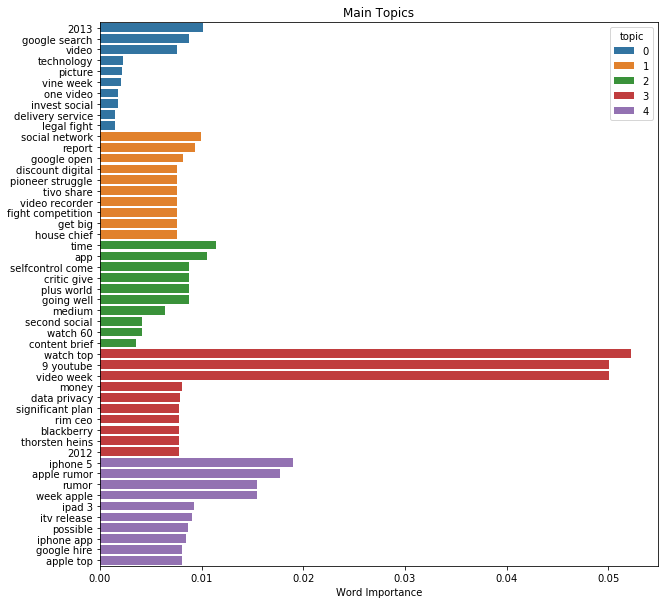

In [35]:
dtf_topics = pd.DataFrame()
for y in dtf["y"].unique():
    print("# {}:".format(y))
    lda, dtf_y = fit_lda(corpus=dtf[dtf["y"]==y]["text_clean"], ngrams=2, grams_join=" ", n_topics=5, figsize=(10,10))
    dtf_y["y"] = y
    dtf_topics = dtf_topics.append(dtf_y)
    print(" ")

In [36]:
dtf_topics.sample(5)

,topic,id,word,weight,y
32,3,15432,paul mccartney,0.004098,ENTERTAINMENT
18,1,38182,president obama,0.003987,POLITICS
13,1,6211,discount digital,0.007546,TECH
25,2,6236,going well,0.008739,TECH
24,2,4302,paul simon,0.003035,ENTERTAINMENT


In [37]:
# It doesn't seem useful.
# I could add some words count with add_word_freq()

###### Summary

In [38]:
# keeping all the features
dtf.head()

,y,text,lang,text_tagged,tags,tags_PRODUCT,tags_GPE,tags_LOC,tags_PERSON,tags_FAC,...,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment,box office,republican,apple
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,Will_Smith Joins Diplo And Nicky_Jam For The_2...,"[{('Will Smith', 'PERSON'): 1}, {('Diplo', 'PE...",0,0,0,3,0,...,smith join diplo nicky jam 2018 world cup offi...,10,46,1,4.600000,10.0,0.500,0,0,0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,Hugh_Grant_Marries For The First Time At Age 57,"[{('Hugh Grant Marries', 'PERSON'): 1}]",0,0,0,1,0,...,hugh grant marries first time age 57,7,30,1,4.285714,7.0,0.625,0,0,0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,Jim_Carrey Blasts 'Castrato' Adam_Schiff And D...,"[{('Jim Carrey', 'PERSON'): 1}, {('Adam Schiff...",0,0,0,2,0,...,jim carrey blast castrato adam schiff democrat...,8,47,1,5.875000,8.0,0.500,0,0,0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,Julianna_Margulies Uses Donald Trump Poop Bags...,"[{('Julianna Margulies', 'PERSON'): 1}]",0,0,0,1,0,...,julianna margulies us donald trump poop bag pi...,9,44,1,4.888889,9.0,0.500,0,0,0
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,Morgan_Freeman_'Devastated' That Sexual Harass...,"[{('Morgan Freeman '', 'ORG'): 1}]",0,0,0,0,0,...,morgan freeman devastated sexual harassment cl...,9,64,1,7.111111,9.0,0.750,0,0,0


### 2 - Preprocessing

###### Encode Target

In [39]:
# not necessary
dtf, dic_y_mapping = add_encode_variable(dtf, "y")

print(dic_y_mapping)
dtf[["y","y_id"]].sample(5)

{0: 'ENTERTAINMENT', 1: 'POLITICS', 2: 'TECH'}


,y,y_id
93825,POLITICS,1
86147,ENTERTAINMENT,0
48583,POLITICS,1
61300,POLITICS,1
186547,TECH,2


###### Partitioning

In [40]:
dtf_train, dtf_test = dtf_partitioning(dtf, y="y", test_size=0.3, shuffle=False)

X_train shape: (34263, 24) | X_test shape: (14685, 24)
y:
  POLITICS  -->  train: 0.71 | test: 0.49
  ENTERTAINMENT  -->  train: 0.26 | test: 0.44
  TECH  -->  train: 0.03 | test: 0.07
25 features: ['text', 'lang', 'text_tagged', 'tags', 'tags_PRODUCT', 'tags_GPE', 'tags_LOC', 'tags_PERSON', 'tags_FAC', 'tags_NORP', 'tags_EVENT', 'tags_WORK_OF_ART', 'tags_ORG', 'text_clean', 'word_count', 'char_count', 'sentence_count', 'avg_word_length', 'avg_sentence_lenght', 'sentiment', 'box office', 'republican', 'apple', 'y_id']


### 3 - Baseline (Bag-of-Words + Machine Learning)

###### Plan:
- Features Engineering with vectorizer
- Features Selection by p-value
- Model Design
- Train / Test
- Evaluate
- Explainability

###### Features Engineering

In [41]:
# Count (classic BoW)
#vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2), lowercase=False)

# Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2), lowercase=False)

In [42]:
dic_bow = fit_bow(corpus=dtf_train["text_clean"], vectorizer=vectorizer, vocabulary=None)

X_train, X_names, vectorizer, dic_vocabulary, lst_text2tokens = dic_bow["X"], dic_bow["X_names"], dic_bow["vectorizer"], dic_bow["dic_vocabulary"], dic_bow["lst_text2tokens"]

--- creating sparse matrix ---
shape: (34263, 10000)
--- creating vocabulary ---
10000 words
--- tokenization ---
34263 texts


In [43]:
# check some features
f_range = (500, 505)

print("fetures name (from dic_vocabulary):")
print({k:v for k,v in sorted(dic_vocabulary.items(), key=lambda item:item[1], reverse=False)
      if v in np.arange(f_range[0], f_range[1]+1, step=1)})

print("")
print("value of these features (in the sparse matrix) for the first text:")
print(vectorizer.get_feature_names()[f_range[0]:f_range[1]])
print(X_train[0, f_range[0]:f_range[1]].todense())

fetures name (from dic_vocabulary):
{'antitrump': 500, 'antitrump protester': 501, 'antitrump republican': 502, 'anton': 503, 'antonin': 504, 'antonin scalia': 505}

value of these features (in the sparse matrix) for the first text:
['antitrump', 'antitrump protester', 'antitrump republican', 'anton', 'antonin']
[[0. 0. 0. 0. 0.]]


In [44]:
# check text conversion
i = 0

## list of text: ["I like this", ...]
len_txt = len(dtf_train["text_clean"].iloc[i].split())
print("from: ", dtf_train["text_clean"].iloc[i], "| len:", len_txt)

## list of token ids: [[1, 2, 3], ...]
len_tokens = len(lst_text2tokens[i])
print("to: ", lst_text2tokens[i], "| len:", len(lst_text2tokens[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", dtf_train["text_clean"].iloc[i].split()[0], " -- idx in vocabulary -->", 
      dic_vocabulary[dtf_train["text_clean"].iloc[i].split()[0]])

## words not in vocabulary?
if len_txt-len_tokens != 0:
    missing_words = [word for word in dtf_train["text_clean"].iloc[i].split() if word not in dic_vocabulary.keys()]
    print("!!!", len_txt-len_tokens, "words not in vocabulary:", missing_words)

from:  smith join diplo nicky jam 2018 world cup official song | len: 10
to:  [8019, 4661, 4533, 60, 9886, 2132, 6081, 8073] | len: 8
check:  smith  -- idx in vocabulary --> 8019
!!! 2 words not in vocabulary: ['diplo', 'nicky']


###### Features Selection

In [45]:
X_names, dtf_selection = features_selection(X_train, dtf_train["y"], X_names, top=None, print_top=10)

features selection: from 10,000 to 3,137
 
# ENTERTAINMENT:
  . selected features: 2694
  . top features: actor, album, amy, award, bachelor, beyoncé, box office, celebrity, chrissy, clinton
 
# POLITICS:
  . selected features: 2774
  . top features: actor, apple, award, celebrity, clinton, dead, donald, donald trump, fan, film
 
# TECH:
  . selected features: 370
  . top features: amazon, android, app, apple, apple fbi, apps, artificial, artificial intelligence, battery, bitcoin
 


In [46]:
dtf_selection.sample(5)

,feature,score,y
4015,health care,1.000000,POLITICS
4215,huffpollster,1.000000,POLITICS
7356,robot,0.999997,POLITICS
7497,ryan reynolds,1.000000,ENTERTAINMENT
9994,zombie,0.972293,ENTERTAINMENT


In [47]:
# Recreate Vectorizer with the selected vocabulary
dic_bow = fit_bow(corpus=dtf_train["text_clean"], vocabulary=X_names)

X_train, X_names, vectorizer, dic_vocabulary, lst_text2tokens = dic_bow["X"], dic_bow["X_names"], dic_bow["vectorizer"], dic_bow["dic_vocabulary"], dic_bow["lst_text2tokens"]

--- creating sparse matrix ---
shape: (34263, 3137)
--- used vocabulary ---
3137 words
--- tokenization ---
34263 texts


In [48]:
# Explore the sparse matrix as dtf
dtf_X_train = sparse2dtf(X_train, dic_vocabulary, X_names, prefix="")

In [49]:
dtf_X_train = pd.concat([dtf_train[["text","y"]], dtf_X_train.set_index(dtf_train.index)], axis=1)
dtf_X_train.head()

,text,y,actor,album,amy,award,bachelor,beyoncé,box office,celebrity,...,hitting,big problem,serial,dont want,city,without,cambridge,cambridge analytica,home,protestors
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Hugh Grant Marries For The First Time At Age 57,ENTERTAINMENT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Julianna Margulies Uses Donald Trump Poop Bags...,ENTERTAINMENT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Morgan Freeman 'Devastated' That Sexual Harass...,ENTERTAINMENT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###### Model Design

In [51]:
classifier = naive_bayes.MultinomialNB()

###### Train / Test

In [50]:
# I already have X_train, I need y_train
y_train = dtf_train["y"].values

# I take the raw text for X_test and I will transform/predict using the pipeline
X_test = dtf_test["text_clean"].values
y_test = dtf_test["y"].values

In [52]:
model, predicted_prob, predicted = ml_text_classif(X_train, y_train, X_test, vectorizer, classifier)

###### Evaluate

Accuracy: 0.85
Auc: 0.94
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.91      0.82      0.87      6444
     POLITICS       0.80      0.97      0.87      7173
         TECH       0.96      0.18      0.31      1068

     accuracy                           0.85     14685
    macro avg       0.89      0.66      0.68     14685
 weighted avg       0.86      0.85      0.83     14685



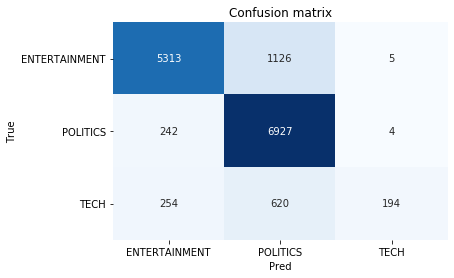

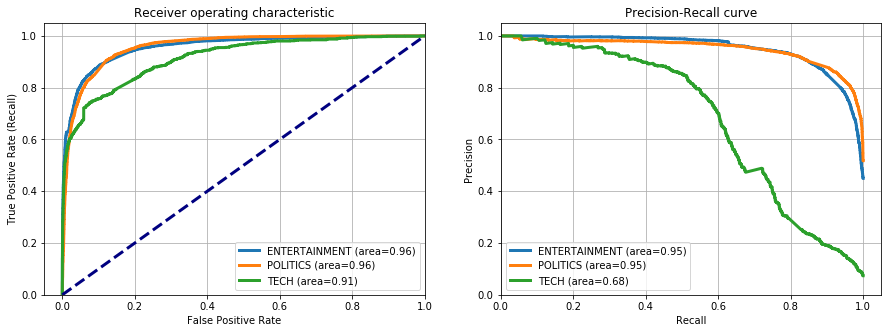

In [53]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5))

###### Explainability

In [54]:
i = 0
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
print(" ")
exp = explainer_lime(model, y_train, txt_instance=dtf_test["text"].iloc[i], top=3)

True: POLITICS --> Pred: POLITICS | Prob: 0.92
 


### 4 - Model Desing & Testing (Embeddings + Deep Learning)

###### Plan:
- Features Engineering with sequence padding
- Load/Train NLP
- Create Weights with word embedding
- Model Design
- Train / Test
- Evaluate
- Explainability

###### Features Engineering

In [153]:
# create input for lstm (sequences of tokens)
X_train, dic_vocabulary = text2seq(corpus=dtf_train["text_clean"], vocabulary=None, maxlen=None, padding='pre')

--- creating sparse matrix ---
shape: (34263, 20630)
--- creating vocabulary ---
20630 words
--- tokenization ---
34263 texts
--- padding to sequence ---
34263 sequences of length 36


In [154]:
# check text conversion
i = 0

## list of text: ["I like this", ...]
len_txt = len(dtf_train["text_clean"].iloc[i].split())
print("from: ", dtf_train["text_clean"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", dtf_train["text_clean"].iloc[i].split()[0], " -- idx in vocabulary -->", 
      dic_vocabulary[dtf_train["text_clean"].iloc[i].split()[0]])

## padding element
print("padding element: ", len(dic_vocabulary))

from:  smith join diplo nicky jam 2018 world cup official song | len: 10
to:  [20630 20630 20630 20630 20630 20630 20630 20630 20630 20630 20630 20630
 20630 20630 20630 20630 20630 20630 20630 20630 20630 20630 20630 20630
 20630 20630 17089 10032  5439 12578  9873   202 20370  4691 12937 17235] | len: 36
check:  smith  -- idx in vocabulary --> 17089
padding element:  20630


In [166]:
# Preprocess Test with the same vocabulary
X_test, _ = text2seq(corpus=dtf_test["text_clean"], vocabulary=dic_vocabulary, maxlen=X_train.shape[1])

--- creating sparse matrix ---
shape: (14685, 20630)
--- used vocabulary ---
20630 words
--- tokenization ---
14685 texts
--- padding to sequence ---
14685 sequences of length 36


###### Load/Train NLP

In [155]:
# Load pre-trained NLP
#nlp = gensim_api.load("glove-wiki-gigaword-300")

In [156]:
# Or train Word2Vec from scratch
avg_len = np.max([len(text.split()) for text in dtf["text_clean"]]) /2 

lst_bigrams_stopwords = ["of","with","without","and","or","the","a"]

lst_corpus, nlp = fit_w2v(corpus=dtf["text_clean"], ngrams=1, min_count=1, size=300, window=avg_len, sg=0, epochs=30, 
                          lst_bigrams_stopwords=lst_bigrams_stopwords)

In [157]:
# check nlp model
nlp["love"].shape

(300,)

<IPython.core.display.Javascript object>


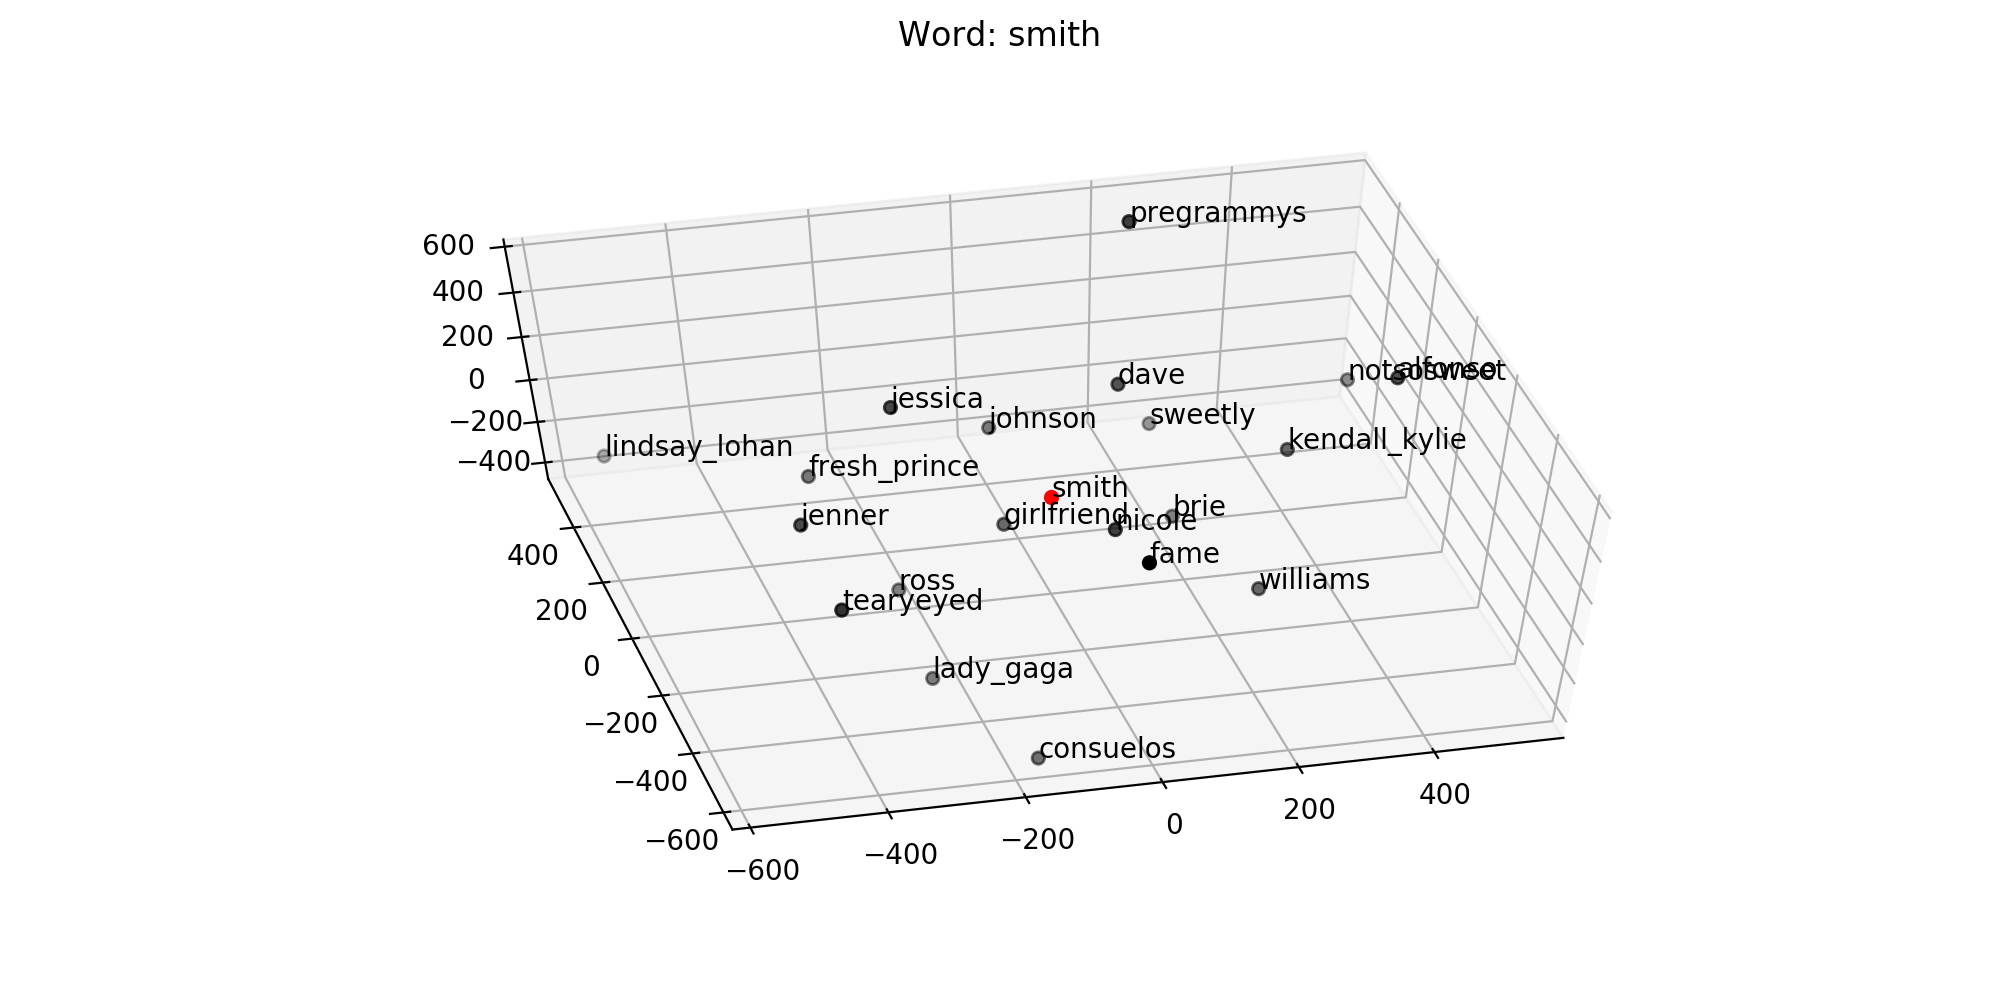

In [191]:
#%matplotlib notebook
plot_w2v(nlp, plot_type="3d", word="love", top=20, figsize=(10,5))

###### Create Weights

In [158]:
embeddings = vocabulary_embeddings(dic_vocabulary, nlp, size=300)

vocabulary mapped to 20631 vectors of size 300


In [159]:
# check
word = dtf_train["text_clean"].iloc[0].split()[0]
print("word:", word)
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, "|vector")

word: smith
dic[word]: 17089 |idx
embeddings[idx]: (300,) |vector


In [160]:
# padding element
print("null vector:", len(embeddings)-1)
embeddings[len(embeddings)-1]

null vector: 20630


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

###### Model Design

In [167]:
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

In [168]:
# LSTM with embeddings as weights and attention layer (for attention explainer)
x_in = layers.Input(shape=(X_train.shape[1],))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0], output_dim=embeddings.shape[1], weights=[embeddings],
                     input_length=X_train.shape[1], trainable=False)(x_in)
## attention
x = attention_layer(x, neurons=X_train.shape[1])
## lstm
x = layers.LSTM(units=X_train.shape[1], dropout=0.2)(x)
y_out = layers.Dense(len(np.unique(y_train)), activation='softmax')(x)

model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [169]:
# Binary version without attention (shap explainer only works with this)

#y_train = pd.get_dummies(dtf_train["y"], drop_first=False).values

#model = models.Sequential([
#    layers.Embedding(input_dim=embeddings.shape[0], output_dim=embeddings.shape[1], weights=[embeddings],
#                     input_length=X_train.shape[1], trainable=False),
#    layers.LSTM(units=X_train.shape[1], dropout=0.2),
#    layers.Dense(3, activation='sigmoid')
#])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#training = model.fit(x=X_train, y=y_train, batch_size=256, epochs=10, shuffle=True, verbose=0, validation_split=0.3)
#utils_plot_keras_training(training)
#predicted_prob = model.predict(X_test)
#predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]

###### Train / Test

In [170]:
y_train = dtf_train["y"].values
y_test = dtf_test["y"].values

{0: 'ENTERTAINMENT', 1: 'POLITICS', 2: 'TECH'}
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 36)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 36, 300)      6189300     input_4[0][0]                    
__________________________________________________________________________________________________
permute_3 (Permute)             (None, 300, 36)      0           embedding_3[0][0]                
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 300, 36)      1332        permute_3[0][0]                  
______________________________________________________________

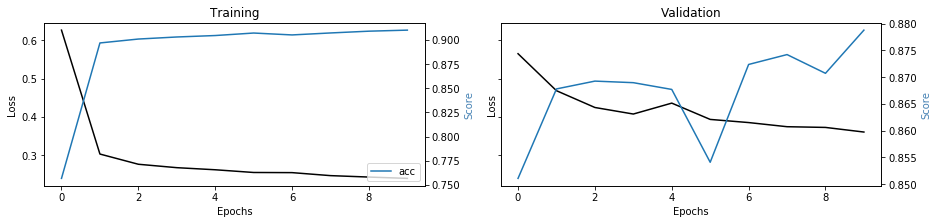

In [171]:
# this takes a while
model, predicted_prob, predicted = dl_text_classif(X_train, y_train, X_test, encode_y=True, 
                                                   model=model, epochs=10, batch_size=256)

###### Evaluate

Accuracy: 0.84
Auc: 0.94
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.86      0.86      0.86      6444
     POLITICS       0.82      0.92      0.87      7173
         TECH       0.96      0.14      0.25      1068

     accuracy                           0.84     14685
    macro avg       0.88      0.64      0.66     14685
 weighted avg       0.85      0.84      0.82     14685



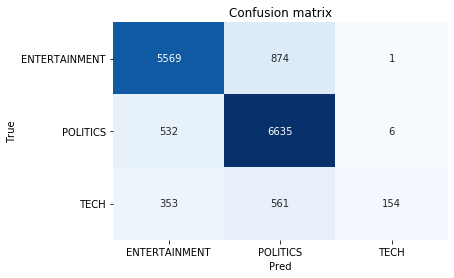

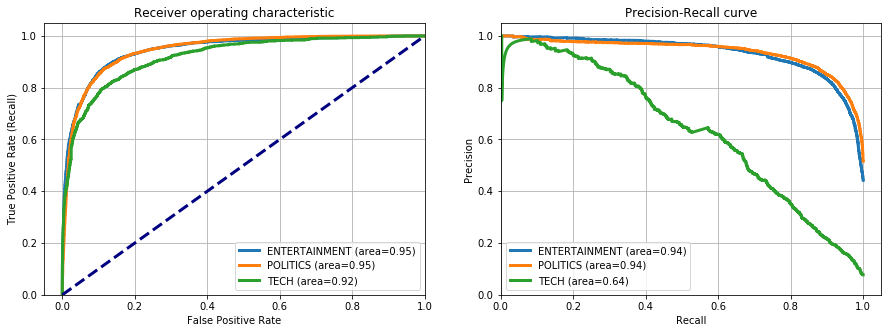

In [172]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5))

###### Explainability

True: POLITICS --> Pred: POLITICS | Prob: 0.51
 


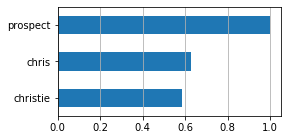

In [173]:
i = 0
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
print(" ")
text_exp = explainer_attention(model, X_test[i], dic_vocabulary, dtf_test["text"].iloc[i], 
                               similarity_thres=0.7, top=3, figsize=(4,2))

from IPython.core.display import display, HTML
display(HTML(text_exp))

### 5 - Model Desing & Testing (Clustering by Similarity)

###### Plan:
- first use the nlp model to create clusters for the classes
- then convert news into vectors and calculate distances

######  Create Clusters

In [59]:
# from the Baseline step
dic_clusters = {}
for y,lst_keywords in dic_features_selection.items():
    if y != "ALL":
        lst_grams = []
        for gram in lst_keywords:
            if len(gram.split())>1:
                lst_grams.append("_".join(gram.split()))
            else:
                lst_grams.append(gram)
        dic_clusters.update({y:lst_grams})

In [60]:
for k,v in dic_clusters.items():
    print(k, ": ", v[0:5], "...")

ENTERTAINMENT :  ['star', 'trump', 'trailer', 'movie', 'oscar'] ...
POLITICS :  ['trump', 'star', 'trailer', 'movie', 'season'] ...
TECH :  ['apple', 'facebook', 'google', 'iphone', 'tech'] ...


###### Fit PCA

In [61]:
pca = fit_pca_w2v(corpus=dtf_train["text_clean"], nlp=nlp)

X shape: (34267, 300)
pca shape: (34267, 300)


###### Predict Clusters

In [65]:
predicted_prob, predicted = predict_clusters_w2v(corpus=dtf_test["text_clean"], dic_clusters=dic_clusters, 
                                                 nlp=nlp, pca=None)

print("Accuracy (overall correct predictions):",  round(metrics.accuracy_score(y_test, predicted),3))
print("Detail:")
print(metrics.classification_report(y_test, predicted))

--- embedding X and y ---
ENTERTAINMENT shape: (300,)
POLITICS shape: (300,)
TECH shape: (300,)
X shape: (14686, 300)
--- computing similarity ---
Accuracy (overall correct predictions): 0.531
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.89      0.72      0.80      6435
     POLITICS       0.64      0.33      0.43      7184
         TECH       0.14      0.74      0.23      1067

     accuracy                           0.53     14686
    macro avg       0.56      0.60      0.49     14686
 weighted avg       0.71      0.53      0.58     14686



###### Evaluate

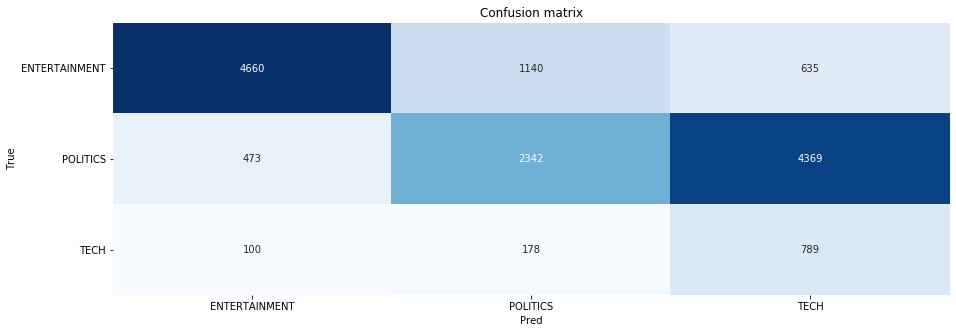

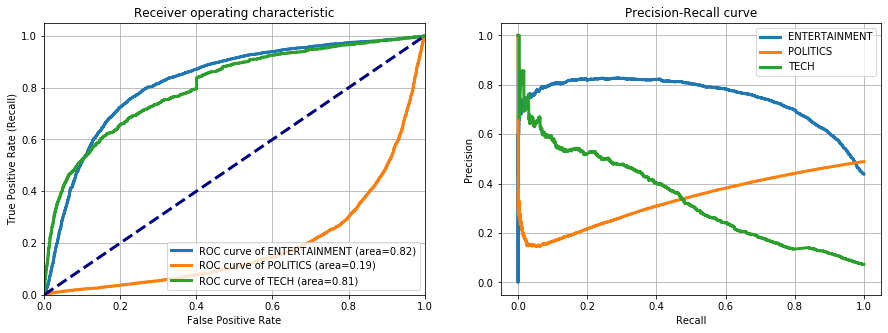

In [66]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5))